## Task 2: Cleaning, Removing Duplicates & Segmenting Payment‑Gateway Companies

### Project Overview
**Context**  
This mini‑project cleans, deduplicates and segments a raw list of payment‑gateway companies scraped online. The end goal is to turn an unstructured CSV into an analysis‑ready dataset that can power market sizing, competitor mapping or outreach strategies.

**Problem statement**  
> “We have a noisy scrape.  How do we turn it into reliable groups we can reason about?”

Specifically we need to:
1. Normalise obvious data quality issues (missing URLs, inconsistent industry tags).  
2. Remove duplicate companies that appear under slight naming variations.  
3. Segement into 3 new fields `size_bucket`, `region`, `sub_sector` so we can slice the market quickly.  
4. Export a clean CSV that any BI tool can use easily without extra handling.

#### STEP 1: Imports & Exploring

In [87]:
import pandas as pd
import re

import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("../data/payment_gateways.csv")
print(f"Raw dataset shape: {data.shape}")
data.head()

Raw dataset shape: (50, 7)


,name,website,location,region,employee_size,industries,keywords
0,Mastercard Payment Gateway Services,NaN,"London, United Kingdom",UK,54.0,Information Technology & Services,pci dss compliance
1,Easy Payment Gateway,http://www.easypaymentgateway.com/,"Mijas, Spain",Europe,19.0,Financial Services,NaN
2,Payment Gateway,http://www.paygatewayonline.com/,"London, United Kingdom",UK,47.0,Financial Services,epos finance
3,BazPAY - Payment Gateway,http://www.bazpay.com/,"London, United Kingdom",UK,3.0,Financial Services,charity; blockchain
4,B2B Payment Gateway,http://www.processingb2b.com/,"Boston, Massachusetts",Americas,1.0,Financial Services,NaN


In [67]:
data.describe()

,employee_size
count,48.000000
mean,40.458333
std,105.279761
min,1.000000
25%,2.000000
50%,3.000000
75%,22.750000
max,500.000000


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           50 non-null     object 
 1   website        32 non-null     object 
 2   location       50 non-null     object 
 3   region         50 non-null     object 
 4   employee_size  48 non-null     float64
 5   industries     48 non-null     object 
 6   keywords       30 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [69]:
data.value_counts()

name                                                       website                           location                 region    employee_size  industries                         keywords               
B1 payment gateway, Malta                                  http://www.b1gate.com/            Montana, US              Americas  1.0            Banking                            easy payment solutions     2
BazPAY - Payment Gateway                                   http://www.bazpay.com/            London, United Kingdom   UK        3.0            Financial Services                 charity; blockchain        2
Cashila, Bitcoin Payment Gateway                           http://www.cashila.com/           Brno, Czechia            Europe    2.0            Financial Services                 payment systems            2
Cpos Payment Gateway                                       http://www.cpos.cloud/            Dover, Delaware          Americas  3.0            Information Technology & Services 

In [70]:
print("this is the length {x}".format(x=len(data)))

this is the length 50


In [71]:
for col in data.columns:
    print(f"\n— {col} —")
    display(data[col].value_counts(dropna=False)) 


— name —


name
Payment Gateway                                                                                         4
Mastercard Payment Gateway Services                                                                     2
Tenerum Payment Gateway, LLC                                                                            2
Pay | Omni-Channel | eCommerce | Payment Gateway | Data Security | Analytics | ERP & CRM Integration    2
KDS CardPay- Payment Gateway for Tech Support                                                           2
B1 payment gateway, Malta                                                                               2
PAYMENT GATEWAY SOLUTIONS LIMITED                                                                       2
StripePros - Payment Gateway Integration Services                                                       2
Zapp Payment Gateway                                                                                    2
T.E Payment Gateway                      


— website —


website
NaN                                   18
http://www.cashila.com/                2
http://www.kdscardpay.com/             2
http://www.b1gate.com/                 2
http://www.stripepros.com/             2
http://www.tepgateway.com/             2
http://www.nimera.io/                  2
http://www.tenerum.com/                2
http://www.cpos.cloud/                 2
http://www.easypaymentgateway.com/     2
http://www.1stprocess.com/             2
http://www.onchainpay.io/              2
http://www.paywithflash.com/           2
http://www.processingb2b.com/          2
http://www.bazpay.com/                 2
http://www.paygatewayonline.com/       2
http://www.fastcharge.com/             2
Name: count, dtype: int64


— location —


location
London, United Kingdom       6
Vilnius, Lithuania           4
Warszawa, Poland             2
Detroit, Michigan            2
Ontario, California          2
Montana, US                  2
England, United Kingdom      2
Santa Clara, California      2
Tempe, Arizona               2
Seal Beach, California       2
Limassol, Cyprus             2
Saint Petersburg, Florida    2
Mijas, Spain                 2
Brno, Czechia                2
Dover, Delaware              2
Las Vegas, Nevada            2
Fremont, California          2
Newark, Delaware             2
Mount Vernon, New York       2
Berlin, Germany              2
Boston, Massachusetts        2
Spokane, Washington          2
Name: count, dtype: int64


— region —


region
Americas    28
Europe      14
UK           8
Name: count, dtype: int64


— employee_size —


employee_size
3.0      12
1.0       8
2.0       8
54.0      2
19.0      2
47.0      2
17.0      2
34.0      2
500.0     2
50.0      2
15.0      2
5.0       2
200.0     2
NaN       2
Name: count, dtype: int64


— industries —


industries
Financial Services                   30
Information Technology & Services     8
Banking                               4
Capital Markets                       2
Management Consulting                 2
+2                                    2
NaN                                   2
Name: count, dtype: int64


— keywords —


keywords
NaN                        20
pci dss compliance          2
epos finance                2
charity; blockchain         2
paypal payment system       2
bitcoin payments            2
crypto                      2
architectural solutions     2
iot; cryptocurrency         2
payment systems             2
lightning network           2
psp                         2
crypto currency             2
stripe developer            2
easy payment solutions      2
payment through master      2
Name: count, dtype: int64

#### STEP 2: Cleaning

In [72]:
# Handling duplicates
data = data.drop_duplicates(subset=["name", "website"], keep="first")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           25 non-null     object 
 1   website        16 non-null     object 
 2   location       25 non-null     object 
 3   region         25 non-null     object 
 4   employee_size  24 non-null     float64
 5   industries     24 non-null     object 
 6   keywords       15 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.6+ KB


Handling missing website URLs

Empty cells (blank or NaN) are replaced with the string **`"Unknown"`** so downstream logic can treat them uniformly.

In [73]:
mask_missing_web = data["website"].isna() | (data["website"].str.strip() == "")
data.loc[mask_missing_web, "website"] = "Unknown"

In [74]:
data["industries"].unique()

array(['Information Technology & Services', 'Financial Services',
       'Capital Markets', 'Management Consulting', 'Banking', '+2', nan],
      dtype=object)

Manual data corrections

1. **`StripePros`** – overwrite self-researched industry on the +2 value

2. **`FastCharge Payment Gateway`** – removed entry due to insufficient data on industry or employee_size.

In [75]:
is_stripepros = data["name"].str.contains("stripepros", case=False, na=False)
data.loc[is_stripepros, "industries"] = "Information Technology & Services"

is_fastcharge = data["name"].str.contains("fastcharge payment gateway", case=False, na=False)
data = data[~is_fastcharge]

#### STEP 3: Segmentation

1. Segmenting the **employee_size** field into 4 range buckets for easier analysis.

In [76]:
size_pattern = re.compile(r"(\d+)")

def size_bucket(cell):
    if pd.isna(cell):
        return "Unknown"
    match = size_pattern.search(str(cell).replace(",", ""))
    if not match:
        return "Unknown"
    n = int(match.group(1))
    if n < 20:
        return "Micro (1‑19)"
    elif n < 100:
        return "Small (20‑99)"
    elif n < 500:
        return "Mid (100‑499)"
    elif n < 2000:
        return "Large (500‑1999)"
    else:
        return "Enterprise (2000+)"

# Apply & store
data["size_bucket"] = data["employee_size"].apply(size_bucket)

2. Sub‑sector tagging (keyword‑driven)

In [77]:
data["keywords"].unique()

array(['pci dss compliance', nan, 'epos finance', 'charity; blockchain',
       'paypal payment system', 'bitcoin payments', 'crypto',
       'architectural solutions', 'iot; cryptocurrency',
       'payment systems', 'lightning network', 'psp', 'crypto currency',
       'stripe developer', 'easy payment solutions',
       'payment through master'], dtype=object)

In [78]:
SECTOR_RULES = [
    ("Crypto / Digital Assets",  ["crypto", "bitcoin", "blockchain", "cryptocurrency", "lightning"]),
    ("POS Solutions",             ["pos", "epos", "retail"]),
    ("Developer‑friendly APIs",   ["stripe", "developer", "api", "sdk", "architectural"]),
    ("Cross‑border / FX",         ["cross-border", "international", "fx"]),
]

def tag_subsector(keyword_str):
    if pd.isna(keyword_str) or keyword_str.strip() == "":
        return "General Gateway"
    kw_lower = keyword_str.lower()
    for label, needles in SECTOR_RULES:
        if any(n in kw_lower for n in needles):
            return label
    return "General Gateway"

# Apply
data["sub_sector"] = data["keywords"].apply(tag_subsector)

#### STEP 4: Exporting

In [82]:
final_file_path = "../data/segmented_payment_gateway_companies.csv"
data.to_csv(final_file_path, index=False)

In [80]:
summary = (
    data.groupby(["region", "size_bucket"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)
summary

size_bucket,Large (500‑1999),Micro (1‑19),Mid (100‑499),Small (20‑99)
region,,,,
Americas,1,9,1,2
Europe,0,7,0,0
UK,0,2,0,2


#### STEP 5: Descriptive Statistics

Before jumping into fancier techniques, I’ll explore the cleaned dataset with simple counts and pivot tables.

Key questions to answer:

* What is the overall distribution of `region`, `size_bucket`, and `sub_sector`?  
* How do sub-sectors vary by region?  
* Are there noticeable gaps (e.g. many “Unknown” employee sizes in a given region)?


In [85]:
# Overall counts for the three categorical dimensions
for col in ["region", "size_bucket", "sub_sector"]:
    display(data[col].value_counts().to_frame("count").style.set_caption(col))

# Region × Sub-sector cross-tab
pivot_rs = (
    data.pivot_table(index="region",
                   columns="sub_sector",
                   aggfunc="size",
                   fill_value=0)
)
display(pivot_rs.style.set_caption("Region × Sub-sector"))

# Region × Size_bucket cross-tab
pivot_rsz = (
    data.pivot_table(index="region",
                   columns="size_bucket",
                   aggfunc="size",
                   fill_value=0)
)
display(pivot_rsz.style.set_caption("Region × Size Bucket"))

,count
region,
Americas,13
Europe,7
UK,4


,count
size_bucket,
Micro (1‑19),18
Small (20‑99),4
Large (500‑1999),1
Mid (100‑499),1


,count
sub_sector,
General Gateway,15
Crypto / Digital Assets,6
Developer‑friendly APIs,2
POS Solutions,1


sub_sector,Crypto / Digital Assets,Developer‑friendly APIs,General Gateway,POS Solutions
region,,,,
Americas,3,2,8,0
Europe,2,0,5,0
UK,1,0,2,1


size_bucket,Large (500‑1999),Micro (1‑19),Mid (100‑499),Small (20‑99)
region,,,,
Americas,1,9,1,2
Europe,0,7,0,0
UK,0,2,0,2


<Axes: title={'center': 'Sub-sectors per Region'}, xlabel='region'>

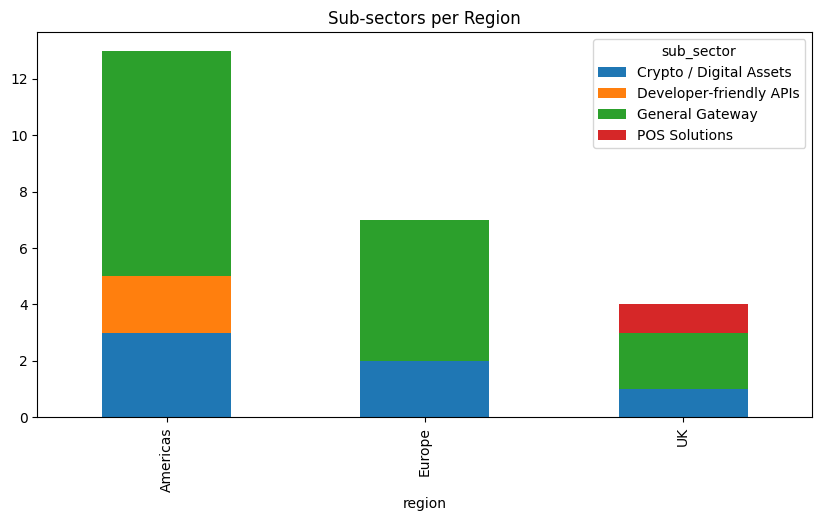

In [94]:
pivot_rs.plot(kind="bar", stacked=True, figsize=(10,5), title="Sub-sectors per Region")

### Visual EDA  
A couple of quick bar charts give an immediate feel for dominant segments, potential white-space and any anomalies in employee-size distribution.


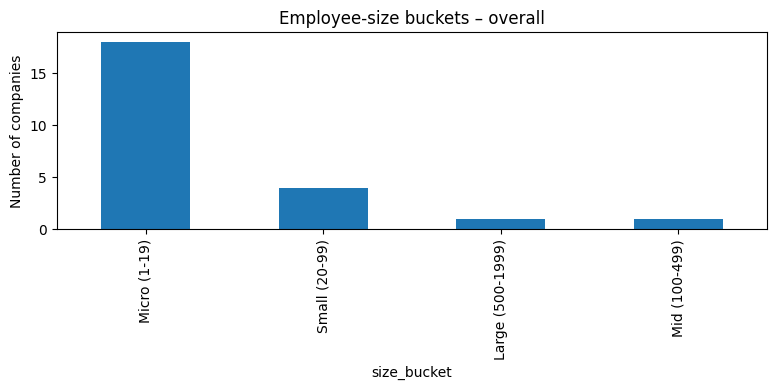

In [ ]:
# Employee-size analysis
fig, ax = plt.subplots(figsize=(8,4))
data["size_bucket"].value_counts().plot(kind="bar", ax=ax, title="Employee-size buckets – overall")
ax.set_ylabel("Number of companies")
plt.tight_layout()

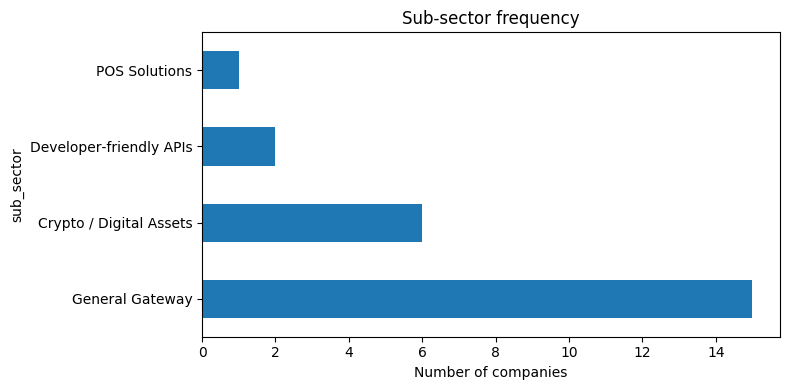

In [95]:
# Sub-sector analysis
fig, ax = plt.subplots(figsize=(8,4))
data["sub_sector"].value_counts().plot(kind="barh", ax=ax, title="Sub-sector frequency")
ax.set_xlabel("Number of companies")
plt.tight_layout()


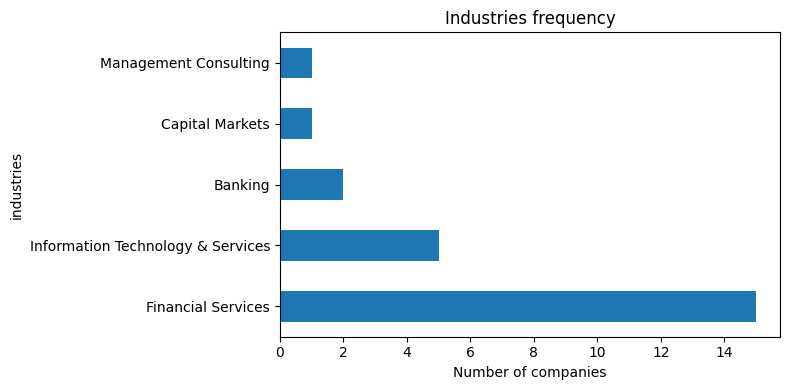

In [96]:
# Industries frequency analysis
fig, ax = plt.subplots(figsize=(8,4))
data["industries"].value_counts().plot(kind="barh", ax=ax, title="Industries frequency")
ax.set_xlabel("Number of companies")
plt.tight_layout()

<Axes: title={'center': 'Industries per Region'}, xlabel='region'>

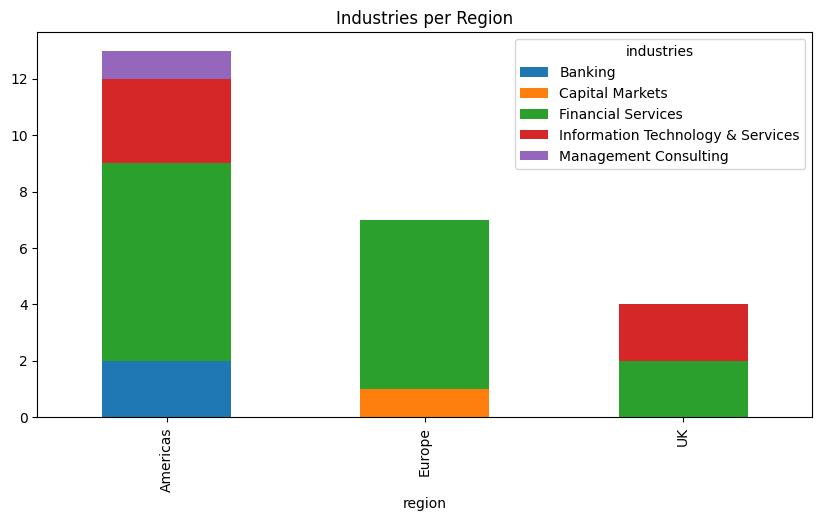

In [93]:
# Region × Industries cross-tab
pivot_ri = (
    data.pivot_table(index="region",
                   columns="industries",
                   aggfunc="size",
                   fill_value=0)
)

pivot_ri.plot(kind="bar", stacked=True, figsize=(10,5), title="Industries per Region")


#### STEP 6: Insights & Next Steps


| Dimension | Biggest bucket | What it tells us |
|-----------|---------------|------------------|
| **Region** | Americas (13 / 24) | The scrape is US-heavy; good for English content, but EU localisation is next. |
| **Size bucket** | Micro (1-19 employees) | Most players are start-ups ⇒ short decision cycles, founder-led sales. |
| **Sub-sector** | General Gateway (15) | Core processing still dominates, but **Crypto (6)** is a fast-growing niche. |
| **Industry tag** | Financial Services (15) | Confirms the FinTech focus rather than pure software. |

### Key takeaways

* **Small teams, big impact.** Three-quarters of the list have < 20 staff. They value hands-on guides and clear pricing more than enterprise Request for Proposals (RFPs).  
* **US first, EU second.** Content must cover both US compliance and EU rules so it becomes relevant for the widest possible audience which can be turned into leads.
* **Crypto is no longer on the edge.** 25 % of companies highlight crypto/bitcoin in their keywords - a clear content pillar opportunity.  
* **Developer voice matters.** Even outside the “Developer-friendly API” tag, most sites pitch “easy integration”, thus, dev-centric assets will land well.

### Next steps for a bigger, better dataset  

1. **Enrich:** pull funding round, founding year and HQ city from Crunchbase/Integrated APIs.  
2. **Grow:** schedule the scraper monthly to spot new entrants & head-count growth.  
3. **Smarter segments:** With 24–25 rows and only one numerical feature (employee size buckets), unsupervised clustering will struggle to add real value. If I expand the dataset (≥ 200 rows) and engineer richer features (funding, age, partnerships, tech stack), clustering becomes useful for campaign grouping. 
4. **Automate dashboards:** plug the cleaned CSV into a Looker Studio board for live monitoring.
